In [1]:
# Install compatible versions issue fix
!pip install -q \
  numpy==1.23.5 \
  torch==2.2.2 \
  torchvision \
  transformers \
  facenet-pytorch \
  kaggle \
  kagglehub \
  seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.40.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but yo

In [3]:
#Installs and Imports + GPU + CLIP
!pip install -q kaggle kagglehub transformers facenet-pytorch

from google.colab import drive, files

import os, random, zipfile, shutil
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
from facenet_pytorch import MTCNN

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

drive.mount('/content/drive')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Mounted at /content/drive


In [4]:
#Dataset Ultilities

# Transforms
clip_normalize = transforms.Normalize(mean=[0.481, 0.457, 0.408], std=[0.268, 0.261, 0.275])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    clip_normalize,
])

# Dataset class initialization
class ImageDataset(Dataset):
    def __init__(self, dataset_path, transform=None, num_samples=20):
        self.dataset_path = dataset_path
        all_images = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.image_filenames = random.sample(all_images, min(num_samples, len(all_images)))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_path, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Function to extract CLIP embeddings from classes
def extract_clip_embeddings(dataloader):
    embeddings = []
    clip_model.eval()

    clip_mean = torch.tensor([0.481, 0.457, 0.408]).view(3, 1, 1).to(device)
    clip_std = torch.tensor([0.268, 0.261, 0.275]).view(3, 1, 1).to(device)

    with torch.no_grad():
        for images in tqdm(dataloader, desc="Extracting CLIP embeddings"):
            images = images.to(device)
            pil_images = [
                transforms.ToPILImage()((img * clip_std + clip_mean).clamp(0, 1)) for img in images
            ]
            inputs = clip_processor(images=pil_images, return_tensors="pt").to(device)
            image_features = clip_model.get_image_features(**inputs)
            embeddings.append(image_features.cpu())

    return torch.cat(embeddings)

#Function to save embeddings
def process_and_save_embeddings(dataset_name, dataset_folder, save_path, num_samples=20, batch_size=16):
    print(f"\nProcessing {dataset_name} dataset")
    dataset = ImageDataset(dataset_folder, transform=transform, num_samples=num_samples)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    embeddings = extract_clip_embeddings(dataloader)
    if embeddings.dim() == 3:
        embeddings = embeddings.squeeze(1)
    torch.save(embeddings, save_path)
    print(f"Saved {dataset_name} embeddings to {save_path}")

#Function that loads the embeddings, so I do not have to call them every single time
def load_embedding(path):
    return torch.load(path).to(device)

datasets = {
      "Human": {
        "folder": "/content/drive/MyDrive/CS131/human_faces",
        "save_path": "/content/drive/MyDrive/CS131/embeddings/human_faces_embedding.pt"
    },
    "Cat": {
        "folder": "/content/drive/MyDrive/CS131/cats",
        "save_path": "/content/drive/MyDrive/CS131/embeddings/cats_embedding.pt"
    },
    "Dog": {
        "folder": "/content/drive/MyDrive/CS131/dog",
        "save_path": "/content/drive/MyDrive/CS131/embeddings/dog_embedding.pt"
    },
    "Halloween Cat Makeup": {
        "folder": "/content/drive/MyDrive/CS131/cat_halloween_makeup",
        "save_path": "/content/drive/MyDrive/CS131/embeddings/cat_halloween_embedding.pt"
    },
    "Halloween Dog Makeup": {
        "folder": "/content/drive/MyDrive/CS131/dog_halloween_makeup",
        "save_path": "/content/drive/MyDrive/CS131/embeddings/dog_halloween_embedding.pt"
    },
    "Puppy Filter": {
        "folder": "/content/drive/MyDrive/CS131/snapchat_filter",
        "save_path": "/content/drive/MyDrive/CS131/embeddings/puppy_filter_embedding.pt"
    }
}
for name, i in datasets.items():
    process_and_save_embeddings(name, i["folder"], i["save_path"], num_samples=50, batch_size=16)


Processing Human dataset


Extracting CLIP embeddings: 100%|██████████| 2/2 [00:10<00:00,  5.10s/it]


Saved Human embeddings to /content/drive/MyDrive/CS131/embeddings/human_faces_embedding.pt

Processing Cat dataset


Extracting CLIP embeddings: 100%|██████████| 3/3 [00:12<00:00,  4.32s/it]


Saved Cat embeddings to /content/drive/MyDrive/CS131/embeddings/cats_embedding.pt

Processing Dog dataset


Extracting CLIP embeddings: 100%|██████████| 2/2 [00:07<00:00,  3.77s/it]


Saved Dog embeddings to /content/drive/MyDrive/CS131/embeddings/dog_embedding.pt

Processing Halloween Cat Makeup dataset


Extracting CLIP embeddings: 100%|██████████| 1/1 [00:05<00:00,  5.32s/it]


Saved Halloween Cat Makeup embeddings to /content/drive/MyDrive/CS131/embeddings/cat_halloween_embedding.pt

Processing Halloween Dog Makeup dataset


Extracting CLIP embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


Saved Halloween Dog Makeup embeddings to /content/drive/MyDrive/CS131/embeddings/dog_halloween_embedding.pt

Processing Puppy Filter dataset


Extracting CLIP embeddings: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Saved Puppy Filter embeddings to /content/drive/MyDrive/CS131/embeddings/puppy_filter_embedding.pt


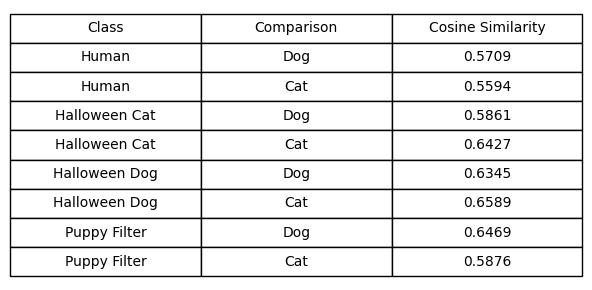

In [5]:
# Cosine Similarity Calculation

# Function to compute cosine similarity
def compute_cosine_similarity(emb1, emb2):
    emb1 = F.normalize(emb1, p=2, dim=-1)
    emb2 = F.normalize(emb2, p=2, dim=-1)
    return torch.matmul(emb1, emb2.T).mean().item()

# Load Embedding Funtion Called
emb = {name: load_embedding(info["save_path"]) for name, info in datasets.items()}

# Data
data = [
    ["Human", "Dog", f"{compute_cosine_similarity(emb['Human'], emb['Dog']):.4f}"],
    ["Human", "Cat", f"{compute_cosine_similarity(emb['Human'], emb['Cat']):.4f}"],
    ["Halloween Cat", "Dog", f"{compute_cosine_similarity(emb['Halloween Cat Makeup'], emb['Dog']):.4f}"],
    ["Halloween Cat", "Cat", f"{compute_cosine_similarity(emb['Halloween Cat Makeup'], emb['Cat']):.4f}"],
    ["Halloween Dog", "Dog", f"{compute_cosine_similarity(emb['Halloween Dog Makeup'], emb['Dog']):.4f}"],
    ["Halloween Dog", "Cat", f"{compute_cosine_similarity(emb['Halloween Dog Makeup'], emb['Cat']):.4f}"],
    ["Puppy Filter", "Dog", f"{compute_cosine_similarity(emb['Puppy Filter'], emb['Dog']):.4f}"],
    ["Puppy Filter", "Cat", f"{compute_cosine_similarity(emb['Puppy Filter'], emb['Cat']):.4f}"]
]

# Plot
columns = ["Class", "Comparison", "Cosine Similarity"]
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')
table = ax.table(cellText=data, colLabels=columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.tight_layout()
plt.show()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f8563c1c860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72

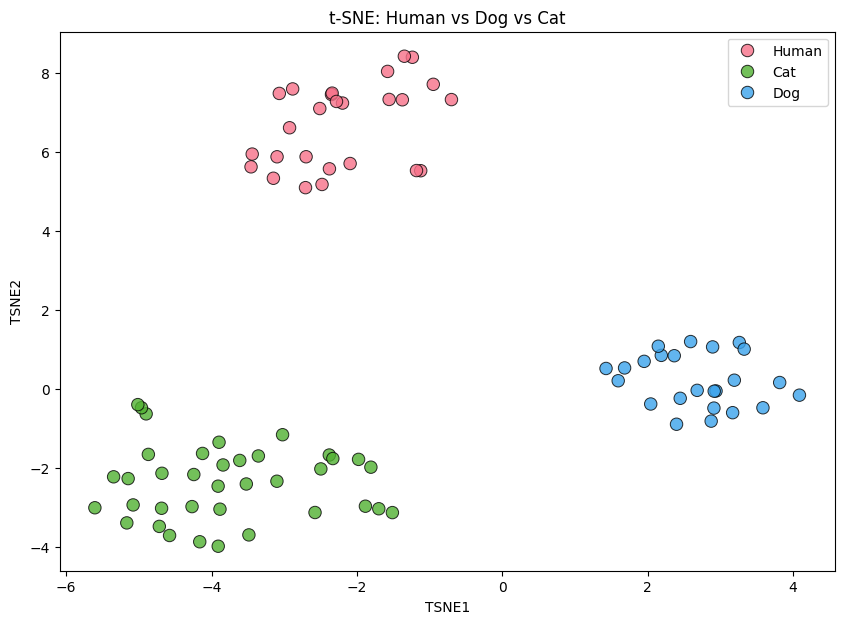

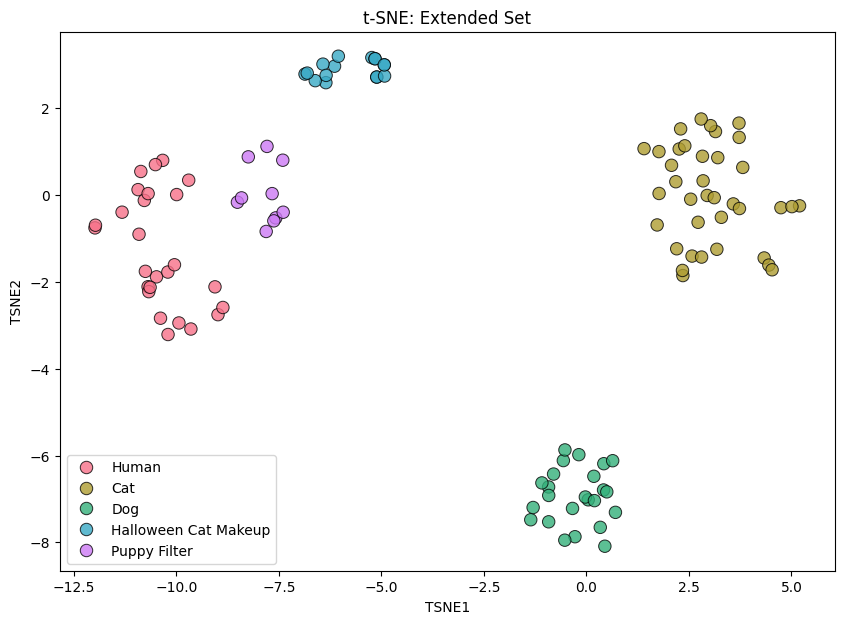

In [6]:
# Function to display th t-SNE between classes
def tsne_visualizer(embedding_dict, title="t-SNE"):
    all_embeddings = []
    all_labels = []
    for label, embs in embedding_dict.items():
        all_embeddings.append(embs.cpu().numpy())
        all_labels.extend([label] * embs.shape[0])

    all_embeddings = np.vstack(all_embeddings)
    pca = PCA(n_components=min(10, all_embeddings.shape[1]))
    pca_embeddings = pca.fit_transform(all_embeddings)

    tsne = TSNE(n_components=2, perplexity=30, max_iter=2000, random_state=42)
    tsne_results = tsne.fit_transform(pca_embeddings)

    # Plot
    df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
    df["Label"] = all_labels
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="Label", palette="husl", alpha=0.8, edgecolor="black", s=80)
    plt.title(title)
    plt.legend()
    plt.show()

tsne_visualizer({k: v for k, v in emb.items() if k in ["Human", "Dog", "Cat"]}, "t-SNE: Human vs Dog vs Cat")
tsne_visualizer({k: v for k, v in emb.items() if k != "Halloween Dog Makeup"}, "t-SNE: Extended Set")

In [7]:
# K-means Computation

from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

# Function to run K-means algorithm
def kmeans(features, k=3, num_iters=100):
    N, D = features.shape
    assert N >= k

    centers = features[np.random.choice(N, k, replace=False)]
    for _ in range(num_iters):
        distances = cdist(features, centers, metric='euclidean')
        assignments = np.argmin(distances, axis=1)
        for j in range(k):
            cluster_points = features[assignments == j]
            if len(cluster_points) > 0:
                centers[j] = cluster_points.mean(axis=0)
    return centers, assignments

# Function to assign each cluster to a category
def assign_cluster_labels(centers, category_embeddings):
    cluster_labels = {}
    for label, emb in category_embeddings.items():
        mean_dists = [np.mean(cdist(emb, [center])) for center in centers]
        assigned_cluster = np.argmin(mean_dists)
        cluster_labels[assigned_cluster] = label
    return cluster_labels

# Function to display graph of K-means results
def visualize_kmeans_tsne(embeddings, assignments, title="K-Means + t-SNE"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
    df["Cluster"] = assignments
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="Cluster", palette="deep", alpha=0.8)
    plt.title(title)
    plt.legend(title="Cluster")
    plt.show()

# Function to show a sample of each of the determined clusters
def show_cluster_samples(assignments, all_image_paths, cluster_num, num_samples=5):
    indices = np.where(assignments == cluster_num)[0]
    chosen = random.sample(list(indices), min(num_samples, len(indices)))
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(chosen):
        img = Image.open(all_image_paths[idx]).convert("RGB")
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Sample Images from Cluster {cluster_num}")
    plt.show()

Cluster → Label Mapping:
{0: 'Human', 1: 'Dog', 2: 'Cat'}
Ignoring Human Cluster: 0
Using Clusters: {1: 'Dog', 2: 'Cat'}


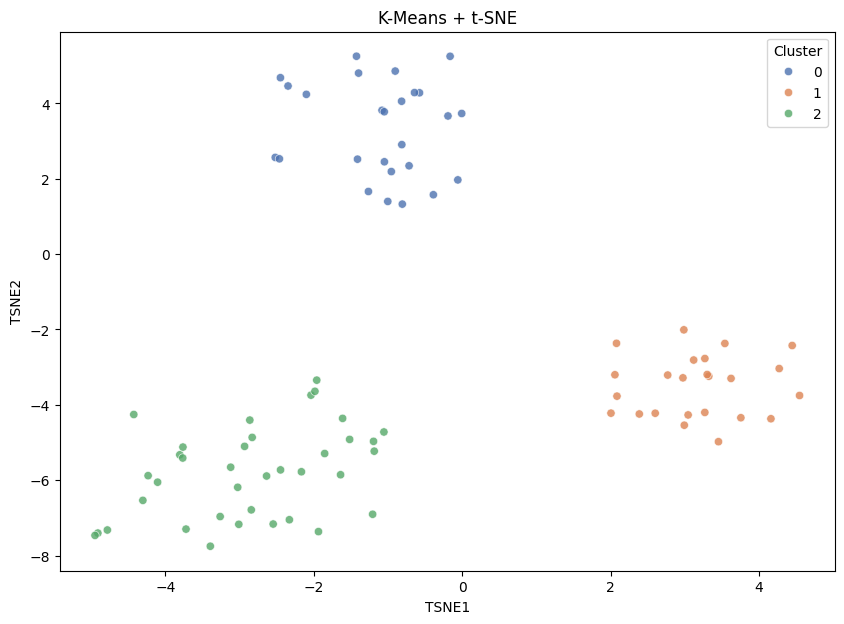

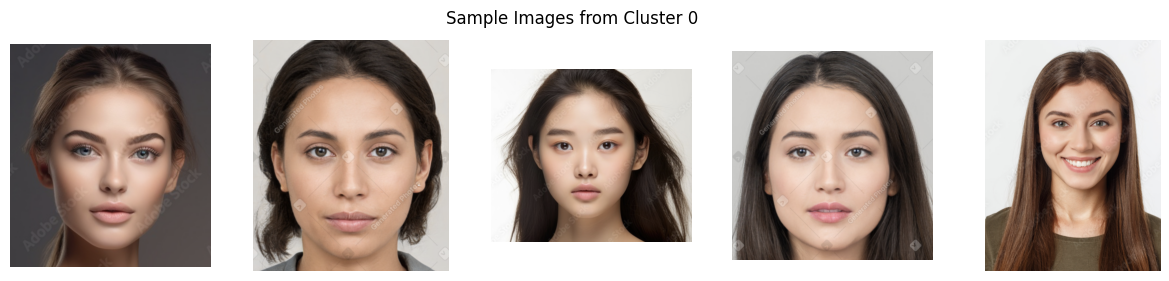

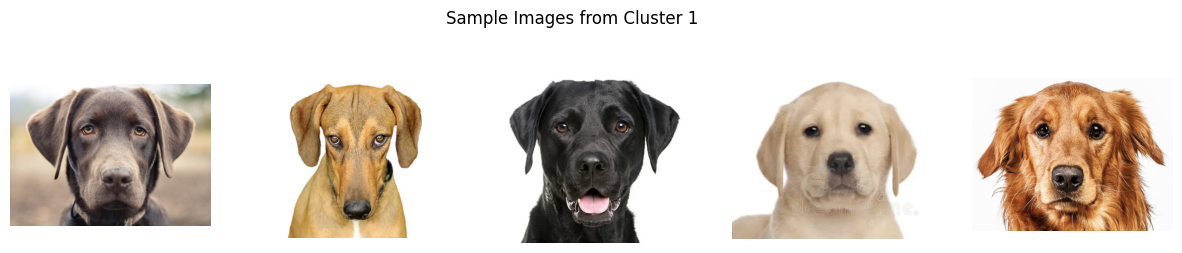

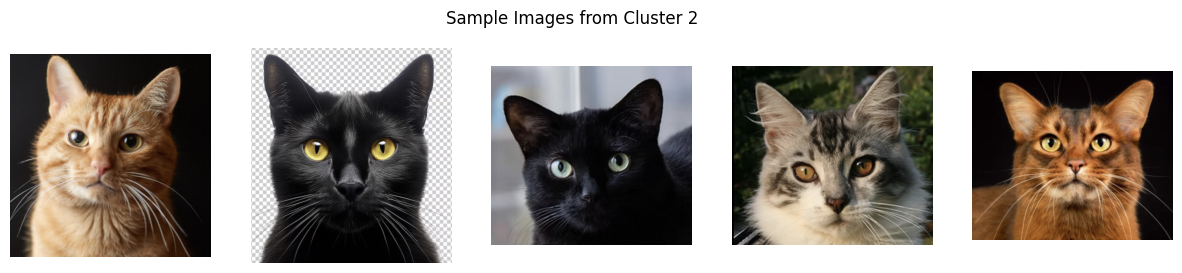

Cluster → Label Mapping:
{1: 'Dog', 2: 'Cat'}


In [8]:
# K-means Visualization (Rerun, if there is a faulty clustering, happens every once if a while)

base_path = "/content/drive/MyDrive/CS131"
datasets_simple = {
    "Human": {"folder": f"{base_path}/human_faces", "embedding": emb["Human"].cpu().numpy()},
    "Dog": {"folder": f"{base_path}/dog", "embedding": emb["Dog"].cpu().numpy()},
    "Cat": {"folder": f"{base_path}/cats", "embedding": emb["Cat"].cpu().numpy()}
}

embeddings = []
labels = []
img_paths = []

for label, info in datasets_simple.items():
    embs = info["embedding"]
    files = sorted(os.listdir(info["folder"]))[:embs.shape[0]]
    embeddings.append(embs)
    labels.extend([label] * embs.shape[0])
    img_paths.extend([os.path.join(info["folder"], f) for f in files])

embeddings = np.vstack(embeddings)


k = 3 # Becuase 3 clusters are what is desired: human, cat, dog
centers, assignments = kmeans(embeddings, k)

# Define cluster labels
cluster_labels = assign_cluster_labels(centers, {
    "Human": datasets_simple["Human"]["embedding"],
    "Dog": datasets_simple["Dog"]["embedding"],
    "Cat": datasets_simple["Cat"]["embedding"],
})

print("Cluster → Label Mapping:")
print(cluster_labels)

# Ignore Human Cluster due to irrelavency
human_cluster = [c for c, lbl in cluster_labels.items() if lbl == "Human"][0]
del cluster_labels[human_cluster]
print(f"Ignoring Human Cluster: {human_cluster}")
print(f"Using Clusters: {cluster_labels}")

visualize_kmeans_tsne(embeddings, assignments)
for cluster_id in range(k):
    show_cluster_samples(assignments, img_paths, cluster_id)

#Cluster Stats
print("Cluster → Label Mapping:")
print(cluster_labels)

Dev Patel.png → Predicted: Dog | Dog: 51.08% | Cat: 48.92%
Screenshot 2025-03-17 at 3.35.27 PM.png → Predicted: Cat | Dog: 49.73% | Cat: 50.27%
Screenshot 2025-03-18 at 10.54.51 AM.png → Predicted: Cat | Dog: 49.47% | Cat: 50.53%
Screenshot 2025-03-18 at 4.41.25 AM.png → Predicted: Cat | Dog: 48.78% | Cat: 51.22%
Screenshot 2025-03-18 at 4.46.27 AM.png → Predicted: Dog | Dog: 50.06% | Cat: 49.94%
Screenshot 2025-03-18 at 4.51.47 AM.png → Predicted: Cat | Dog: 49.13% | Cat: 50.87%
Screenshot 2025-03-18 at 5.14.51 AM.png → Predicted: Dog | Dog: 50.17% | Cat: 49.83%
Screenshot 2025-03-18 at 5.20.05 AM.png → Predicted: Dog | Dog: 50.86% | Cat: 49.14%
Screenshot 2025-03-21 at 2.48.42 PM.png → Predicted: Dog | Dog: 50.96% | Cat: 49.04%
Screenshot 2025-03-21 at 2.50.05 PM.png → Predicted: Cat | Dog: 49.07% | Cat: 50.93%
Screenshot 2025-03-21 at 2.50.55 PM.png → Predicted: Cat | Dog: 48.80% | Cat: 51.20%
Screenshot 2025-03-21 at 2.51.35 PM.png → Predicted: Dog | Dog: 51.24% | Cat: 48.76%
Scree

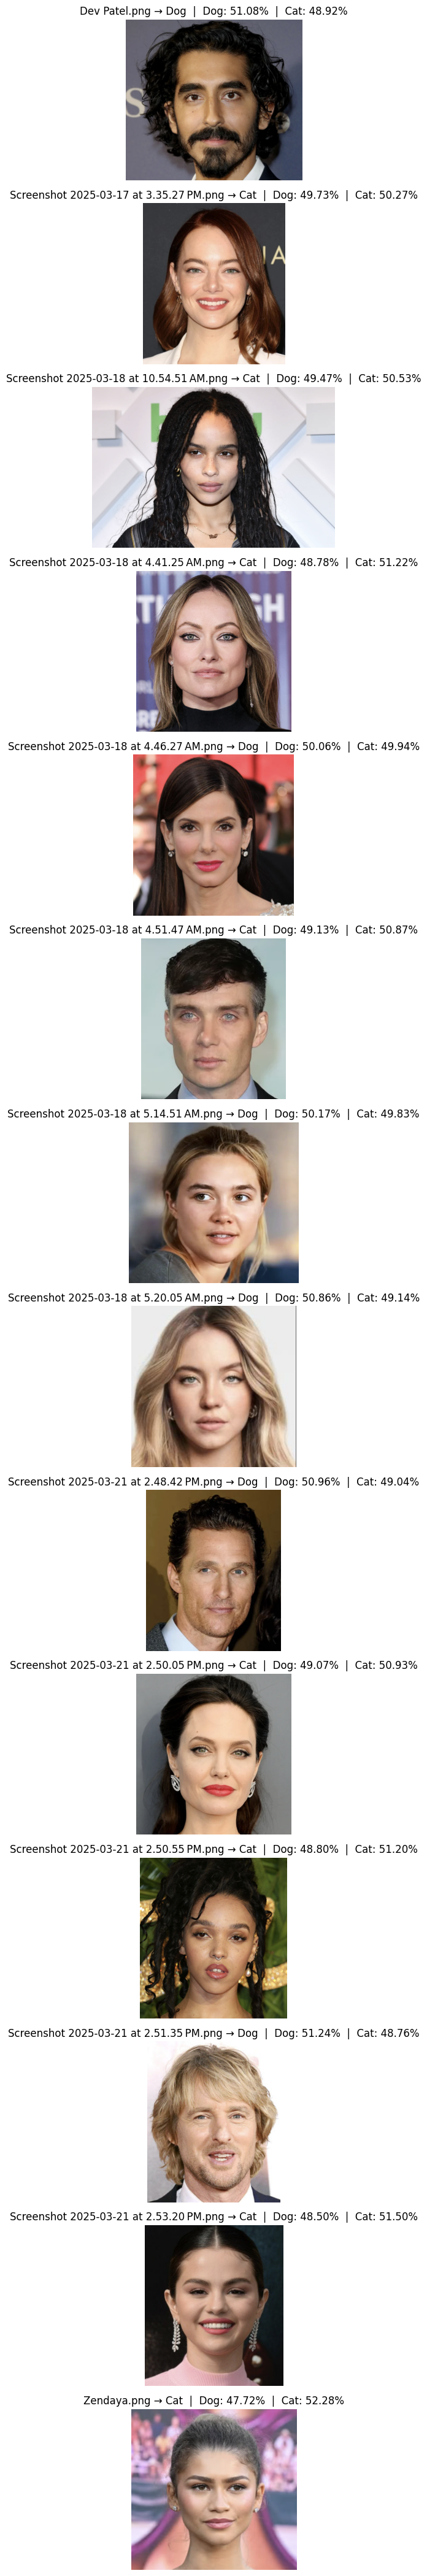

In [9]:
# Function to classify a human face as a cat or a dog

def classify_human_face_embedding(embedding, centers, cluster_labels):
    distances = {
        cluster: 1 - np.dot(embedding, centers[cluster]) / (np.linalg.norm(embedding) * np.linalg.norm(centers[cluster]))
        for cluster in cluster_labels
   }
    closest = min(distances, key=distances.get)
    return cluster_labels[closest]

# Function to display the classifed human faces
def classify_and_display_images(folder, num_samples=5):
    files = sorted([
        f for f in os.listdir(folder)
        if os.path.isfile(os.path.join(folder, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])[:num_samples]




    def classify_with_confidence(embedding):
        distances = {
            cluster: 1 - np.dot(embedding, centers[cluster]) / (np.linalg.norm(embedding) * np.linalg.norm(centers[cluster]))
            for cluster in cluster_labels
        }

        inverse_distances = {k: 1 / (v + 1e-6) for k, v in distances.items()}
        total = sum(inverse_distances.values())
        confidences = {cluster_labels[k]: (v / total) * 100 for k, v in inverse_distances.items()}
        predicted = max(confidences, key=confidences.get)
        return predicted, confidences

    plt.figure(figsize=(15, 3 * num_samples))

    for i, fname in enumerate(files):
        path = os.path.join(folder, fname)
        img = Image.open(path).convert("RGB")

        # Embedding
        inputs = clip_processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            embedding = clip_model.get_image_features(**inputs).cpu().numpy().flatten()

        # Classify with % confidence
        pred, conf = classify_with_confidence(embedding)
        dog_pct = conf.get("Dog", 0)
        cat_pct = conf.get("Cat", 0)

        # Plot
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{fname} → {pred}  |  Dog: {dog_pct:.2f}%  |  Cat: {cat_pct:.2f}%")

        print(f"{fname} → Predicted: {pred} | Dog: {dog_pct:.2f}% | Cat: {cat_pct:.2f}%")

    plt.tight_layout()
    plt.show()

file = "/content/drive/MyDrive/CS131/test_faces"
classify_and_display_images(file, num_samples=50)